In [132]:
import os
import json
import polars as pl

# Název složky, kde jsou uloženy JSON soubory s testy
directory_path = 'parsed_tests'

# Seznam pro ukládání všech otázek ze všech souborů
all_questions = []


# Procházení všech souborů v dané složce
print(f"Prohledávám složku: '{directory_path}'...")
for filename in os.listdir(directory_path):
    # Zpracováváme pouze soubory s příponou .json
    if filename.endswith('.json'):
        file_path = os.path.join(directory_path, filename)

        # Otevření a načtení JSON souboru
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)

                # Získání data testu
                test_date = data.get('datum_testu')
                questions = data.get('prehled_otazek', [])

                # Přidání data testu ke každé otázce a přidání do celkového seznamu
                for question in questions:
                    question['datum_testu'] = test_date
                    all_questions.append(question)

            except json.JSONDecodeError:
                print(f"Chyba při parsování souboru: {filename}")
            except Exception as e:
                print(f"Naskytla se neočekávaná chyba u souboru {filename}: {e}")


# Vytvoření Polars DataFrame ze seznamu všech otázek
if all_questions:
    df = pl.DataFrame(all_questions)

    # Převedení sloupce 'moznosti' z dict na struct pro lepší manipulaci v Polars
    # a datum_testu na datový typ Date
    df = df.with_columns(
        pl.col("moznosti").cast(pl.Struct([
            pl.Field("A", pl.Utf8),
            pl.Field("B", pl.Utf8),
            pl.Field("C", pl.Utf8)
        ])),
        pl.col("datum_testu").str.to_date("%d.%m.%Y", strict=False)
    )

    # Zobrazení prvních několika řádků a schématu DataFrame
    print("\nÚspěšně načteno a zpracováno:")
    print(f"Celkový počet otázek: {len(df)}")
    print("\nSchéma DataFrame:")
    print(df.schema)
else:
    print("\nNebyly nalezeny žádné otázky k načtení.")


print(f"Testy v rozsahu: {max(df['datum_testu'])} - {min(df['datum_testu'])}")
EXPORT_datetime_range = f"{min(df['datum_testu']).strftime('%Y-%m-%d')}_to_{max(df['datum_testu']).strftime('%Y-%m-%d')}"
df

Prohledávám složku: 'parsed_tests'...
Naskytla se neočekávaná chyba u souboru test_966032.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966033.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966034.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966035.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966036.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966037.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966038.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966039.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966040.json: 'NoneType' object has no attribute 'get'
Naskytla se neočekávaná chyba u souboru test_966041.json: 'NoneType' ob

text_otazky,moznosti,spravna_odpoved,body,datum_testu
str,struct[3],str,i64,date
"""Osa zemská je myšlená přímka s…","{""zeměpisné"",""totožné"",""magnetické""}","""A""",3,2025-09-03
"""Hlavní příčinou atmosférické k…","{""rozdílná teplota vzduchu ve dne a v noci"",""dostatečný ohřev vzduchu o zemský povrch při instabilním zvrstvení"",""nestejnoměrné zahřívání různě barevného zemského povrchu""}","""B""",0,2025-09-03
"""Je-li dáván příkaz letadlu na …","{""pojíždění povoleno"",""opusťte přistávací plochu"",""vraťte se na místo odkud jste vyjel""}","""A""",1,2025-09-03
"""Odtržením proudnic rozumíme:""","{""skokový přechod od turbulentního proudění nad horní plochou křídla k absolutní"",""proudnice opustí profil, po tom co opíšou jeho tvar"",""proud vzduchu přestane sledovat tvar profilu""}","""C""",0,2025-09-03
"""Provádíme levou zatáčku o nákl…","{""skluzovou zatáčku"",""správnou zatáčku"",""výkluzovou zatáčku""}","""C""",0,2025-09-03
…,…,…,…,…
"""Nosnou složkou kompozitní lete…","{""pryskyřice"",""tkanina nebo stejnosměrná skleněná vlákna, nebo vlákna z jiných k tomu určených"",""jemná drátěná síť""}","""B""",0,2025-05-09
"""Oblačnost se v troposféře tvoř…","{""dusíku"",""kyslíku"",""vodní páry""}","""C""",0,2025-05-09
"""Klouzavost vůči zemi se:""","{""fouká-li vítr nezmění, protože efektivní nosná plocha zůstává stejná"",""změní při změně hmotnosti"",""změní, fouká-li vítr""}","""C""",0,2025-05-09


In [133]:
# Seskupení podle textu otázky a provedení agregace pro ostatní sloupce
df_grouped = df.group_by("text_otazky").agg(
    # Spočítáme, kolikrát se každá otázka vyskytla
    pl.len().alias("pocet_vyskytu"),

    # Pro sloupce, které by měly být pro danou otázku vždy stejné, vezmeme první výskyt
    pl.col("moznosti").first().alias("moznosti"),
    pl.col("spravna_odpoved").first().alias("spravna_odpoved"),

    # Vezmeme MAXIMÁLNÍ hodnotu bodů, abychom se "zbavili" nul, pokud existuje i nenulová varianta
    pl.col("body").max().alias("body"),

    # Zaznamenáme, zda pro danou otázku existovala i varianta s 0 body
    (pl.col("body") == 0).any().alias("obsahuje_variantu_s_0_body"),

    # Zjistíme datum, kdy se otázka objevila naposledy
    pl.col("datum_testu").max().alias("posledni_datum_testu")

).sort("pocet_vyskytu", descending=True) # Seřadíme výsledek podle četnosti

# Zobrazení výsledného unikátního a agregovaného DataFrame
print("Byl vytvořen nový DataFrame 'df_grouped' s unikátními otázkami.")
print(f"Původní počet záznamů: {len(df)}")
print(f"Nový počet unikátních otázek: {len(df_grouped)}")

df_grouped

Byl vytvořen nový DataFrame 'df_grouped' s unikátními otázkami.
Původní počet záznamů: 173336
Nový počet unikátních otázek: 977


text_otazky,pocet_vyskytu,moznosti,spravna_odpoved,body,obsahuje_variantu_s_0_body,posledni_datum_testu
str,u32,struct[3],str,i64,bool,date
"""Při laminárním proudění:""",1808,"{""dochází k vzájemnému promíchávání proudnic, ale na konci sledovaného průřezu"",""nedochází k vzájemnému promíchávání proudnic"",""dochází k vzájemnému promíchávání proudnic""}","""B""",1,true,2025-09-05
"""Zeměkoule je:""",1718,"{""síť souřadnicových čar"",""ideální koule"",""rotační elipsoid na pólech zploštělý""}","""C""",1,true,2025-09-05
"""Do jaké výšky lze počítat s „p…",1507,"{""u ULLa do výšky přibližně 20 m"",""do výšky 1 m"",""asi do výšky jako je polovina rozpětí křídla""}","""C""",1,true,2025-09-05
"""Těžiště letadla je:""",1460,"{""působiště tíhové síly"",""působiště výsledné aerodynamické síly"",""působiště výsledné aerodynamické síly a tíhové síly""}","""A""",3,true,2025-09-05
"""Spirála je letový režim, při k…",1346,"{""dochází k odtržení proudění na straně křídla uvnitř zatáčky"",""nedochází k odtržení proudění"",""dochází k odtržení proudění na straně křídla vně zatáčky""}","""B""",3,true,2025-09-05
…,…,…,…,…,…,…
"""Jsou 2 plné láhve s palivem, s…",1,"{""Výkon hořáku bude shodný"",""Pokud bude připojen na láhev s propanem"",""Pokud bude připojen na láhev s LPG""}","""B""",0,true,2025-05-03
"""Tlak v MSA s výškou klesá""",1,"{""stoupá"",""lineárně"",""eponenciálně""}","""C""",0,true,2025-04-22
"""Ovládání předního kola MZK nož…",1,"{""funguje obráceně než u UL letounu"",""funguje stejně jako u UL letounu"",""může být provedeno stejně jako u UL letounu""}","""A""",0,true,2025-09-01


In [134]:
# Zkontrolujeme, zda DataFrame 'question_counts' existuje
if 'question_counts' in locals() and question_counts is not None and len(question_counts) > 0:
    # Importujeme potřebnou knihovnu pro vizualizaci
    import plotly.express as px

    # Vybereme prvních 10 nejčastějších otázek (DataFrame je již seřazen)
    top_10_questions = question_counts.head(50)

    # Vytvoření horizontálního sloupcového grafu
    # Tento typ grafu je ideální pro zobrazení dlouhých textových popisků
    fig = px.bar(
        top_10_questions,
        x="pocet_vyskytu",
        y="text_otazky",
        orientation='h', # Nastavení horizontální orientace
        title=f"Top 50 nejčastějších otázek v {len(os.listdir("parsed_tests"))} testech",
        labels={
            "pocet_vyskytu": "Počet výskytů v testech",
            "text_otazky": "Text otázky"
        },
        text="pocet_vyskytu" # Zobrazí hodnoty přímo na sloupcích
    )

    # Vylepšení vzhledu grafu
    # Seřadíme osu Y tak, aby otázka s nejvyšším počtem byla nahoře
    fig.update_layout(
        yaxis={'categoryorder':'total ascending'},
        height=600 # Zvětšíme výšku grafu, aby se texty vešly
    )

    # Zobrazení grafu
    fig.show()
    fig.to_image(format="png")
else:
    print("DataFrame 'question_counts' neexistuje nebo je prázdný. Spusťte nejprve buňku pro seskupení otázek.")

In [135]:
 # filter where points is 0
df_grouped.filter(pl.col("body") == 0).count()

text_otazky,pocet_vyskytu,moznosti,spravna_odpoved,body,obsahuje_variantu_s_0_body,posledni_datum_testu
u32,u32,u32,u32,u32,u32,u32
35,35,35,35,35,35,35


/tmp/ipykernel_79272/2659013961.py:23: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



Nalezeno 7 týdnů s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...
------------------------------
Histogram pro týden od 14.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-15.png
Histogram pro týden od 21.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-16.png
Histogram pro týden od 28.04.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-17.png
Histogram pro týden od 05.05.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-18.png
Histogram pro týden od 23.06.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-25.png
Histogram pro týden od 25.08.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-34.png
Histogram pro týden od 01.09.2025 byl uložen do souboru: histogram_weeks/top50_questions_2025-35.png

--- Zobrazuji nejnovější graf ---


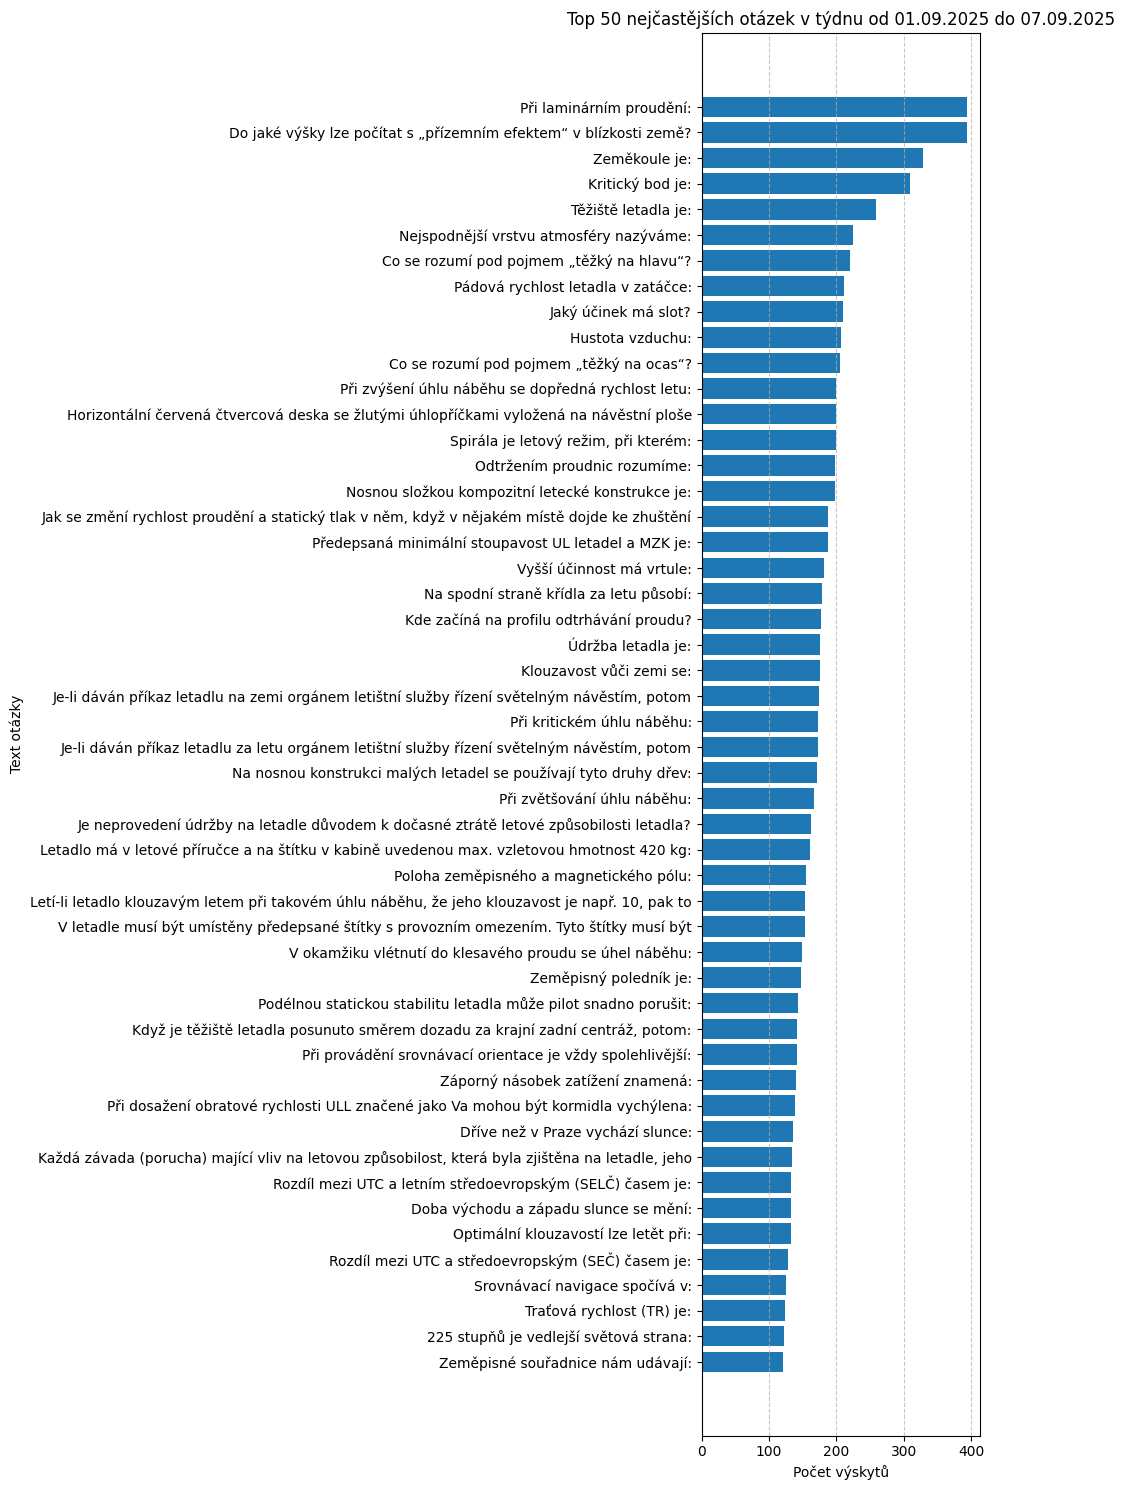

------------------------------
Proměnná 'EXPORT_newest_histogram_week' obsahuje cestu k nejnovějšímu souboru:
histogram_weeks/top50_questions_2025-35.png


In [139]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export
EXPORT_newest_histogram_week = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Přidání sloupce s týdnem
    df_with_week = df.with_columns(
        pl.col("datum_testu").dt.truncate("1w").alias("tyden")
    )

    # 2. KROK: Seskupení otázek podle týdne a textu
    weekly_counts = df_with_week.group_by("tyden", "text_otazky").agg(
        pl.count().alias("pocet_vyskytu")
    ).sort("tyden", "pocet_vyskytu", descending=[False, True])

    # 3. KROK: Získání unikátních týdnů a identifikace toho nejnovějšího
    unique_weeks = weekly_counts.get_column("tyden").unique().sort()

    if not unique_weeks.is_empty():
        # Identifikujeme nejnovější týden PŘED spuštěním smyčky
        newest_week_date = unique_weeks[-1]

        # --- Příprava na export ---
        output_directory = 'histogram_weeks'
        os.makedirs(output_directory, exist_ok=True)
        # Nastavíme exportní proměnnou na název souboru, který BUDE patřit nejnovějšímu grafu
        newest_week_filename_str = newest_week_date.strftime('%Y-%W') # Formát ROK-ČÍSLO TÝDNE
        EXPORT_newest_histogram_week = f"{output_directory}/top50_questions_{newest_week_filename_str}.png"

        print(f"Nalezeno {len(unique_weeks)} týdnů s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...")
        print("-" * 30)

        # 4. KROK: Iterace přes VŠECHNY týdny
        for week_start_date in unique_weeks:
            top_questions_in_week = weekly_counts.filter(
                pl.col("tyden") == week_start_date
            ).head(50)

            # Formátování dat pro titulek a název souboru pro AKTUÁLNÍ týden
            week_end_date = week_start_date + timedelta(days=6)
            start_str = week_start_date.strftime('%d.%m.%Y')
            end_str = week_end_date.strftime('%d.%m.%Y')
            week_filename_str = week_start_date.strftime('%Y-%W')
            current_filename = f"{output_directory}/top50_questions_{week_filename_str}.png"

            # --- Vykreslení grafu ---
            plt.figure(figsize=(10, 15))
            plt.barh(
                top_questions_in_week.get_column("text_otazky"),
                top_questions_in_week.get_column("pocet_vyskytu")
            )
            plt.gca().invert_yaxis()
            plt.xlabel("Počet výskytů")
            plt.ylabel("Text otázky")
            plt.title(f"Top {len(top_questions_in_week)} nejčastějších otázek v týdnu od {start_str} do {end_str}")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()

            # Uložení KAŽDÉHO grafu
            plt.savefig(current_filename)
            print(f"Histogram pro týden od {start_str} byl uložen do souboru: {current_filename}")

            # Zobrazení POUZE nejnovějšího grafu
            if week_start_date == newest_week_date:
                print("\n--- Zobrazuji nejnovější graf ---")
                plt.show()

            # Zavření plátna, aby se uvolnila paměť
            plt.close()

    else:
        print("Nenalezena žádná data pro generování týdenního histogramu.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_newest_histogram_week:
    print(f"Proměnná 'EXPORT_newest_histogram_week' obsahuje cestu k nejnovějšímu souboru:")
    print(EXPORT_newest_histogram_week)
else:
    print("Proměnná 'EXPORT_newest_histogram_week' je prázdná, protože nebyl vygenerován žádný graf.")

/tmp/ipykernel_79272/3291248726.py:23: DeprecationWarning:

`pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)



Nalezeno 5 měsíců s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...
------------------------------
Histogram pro měsíc April 2025 byl uložen do souboru: histogram_month/top50_questions_2025-04.png
Histogram pro měsíc May 2025 byl uložen do souboru: histogram_month/top50_questions_2025-05.png
Histogram pro měsíc June 2025 byl uložen do souboru: histogram_month/top50_questions_2025-06.png
Histogram pro měsíc August 2025 byl uložen do souboru: histogram_month/top50_questions_2025-08.png
Histogram pro měsíc September 2025 byl uložen do souboru: histogram_month/top50_questions_2025-09.png

--- Zobrazuji nejnovější graf ---


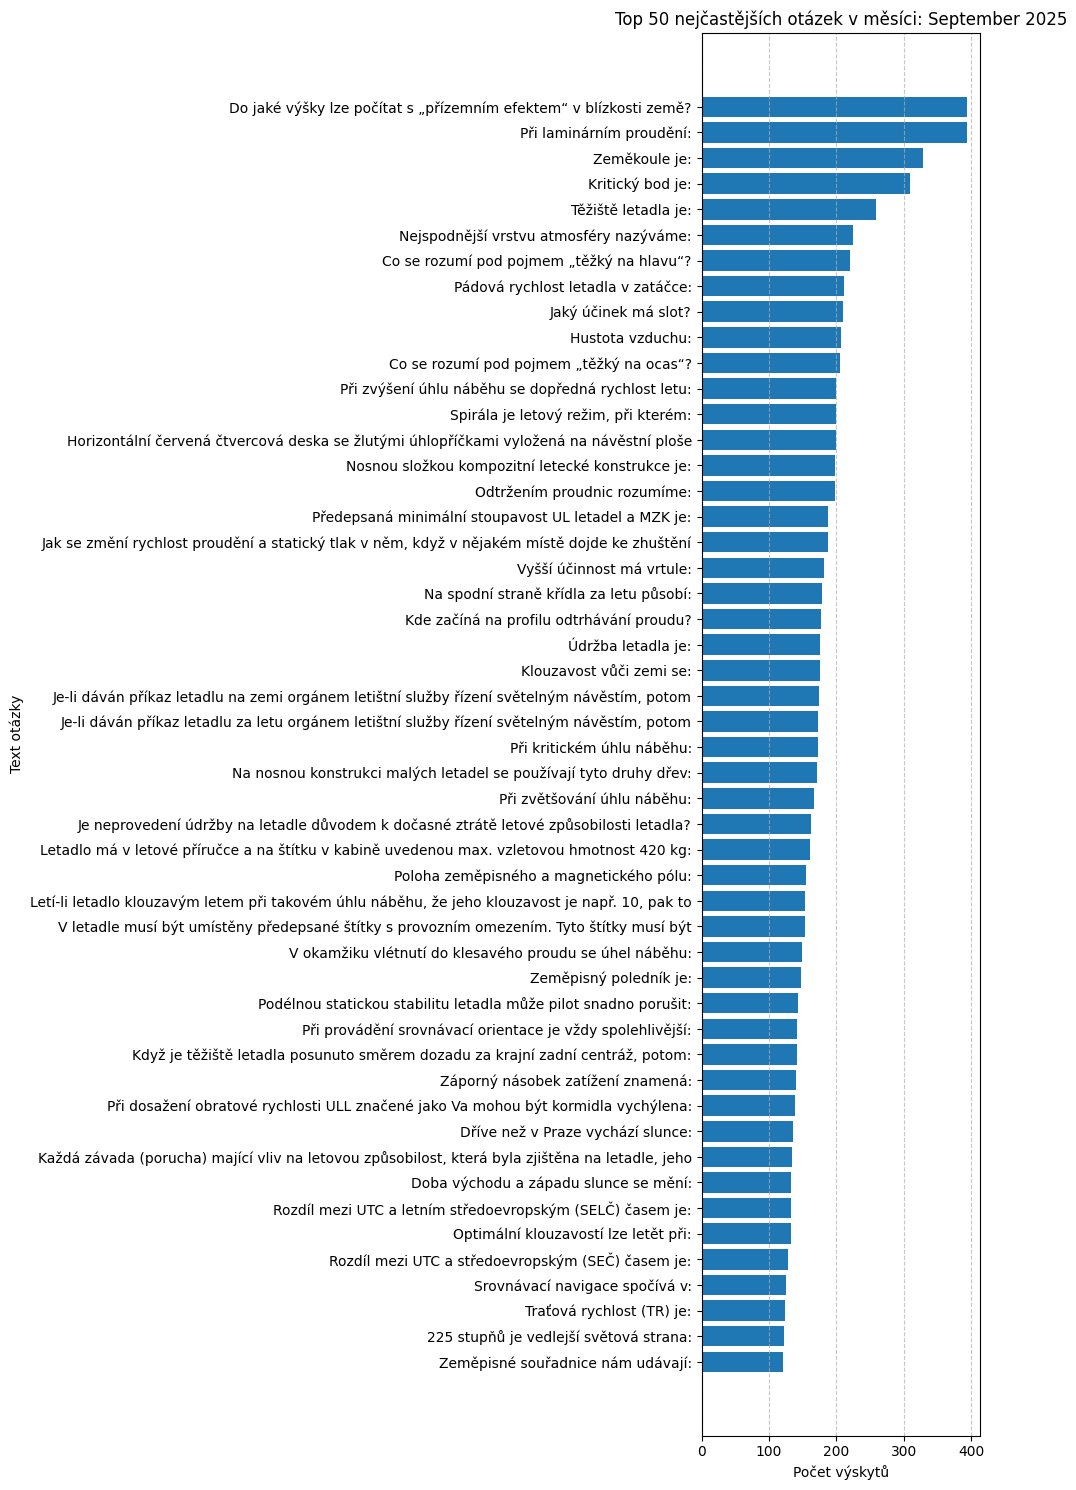

------------------------------
Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:
histogram_month/top50_questions_2025-09.png


In [142]:
import polars as pl
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os # Potřebujeme pro vytvoření složky

# Potlačení varování, které může Polars vyvolat při agregacích s datovými typy
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inicializace proměnné pro export, pro případ, že by se graf nevytvořil
EXPORT_newest_histogram_month = None

# Zkontrolujeme, zda původní DataFrame 'df' existuje
if 'df' in locals() and df is not None and len(df) > 0:

    # 1. KROK: Přidání sloupce s měsícem
    df_with_month = df.with_columns(
        pl.col("datum_testu").dt.truncate("1mo").alias("mesic")
    )

    # 2. KROK: Seskupení otázek podle měsíce a textu
    monthly_counts = df_with_month.group_by("mesic", "text_otazky").agg(
        pl.count().alias("pocet_vyskytu")
    ).sort("mesic", "pocet_vyskytu", descending=[False, True])

    # 3. KROK: Získání unikátních měsíců a identifikace toho nejnovějšího
    unique_months = monthly_counts.get_column("mesic").unique().sort()

    # Zkontrolujeme, zda máme vůbec nějaká data
    if not unique_months.is_empty():
        # Identifikujeme nejnovější měsíc PŘED spuštěním smyčky
        newest_month_date = unique_months[-1]

        # --- Příprava na export ---
        output_directory = 'histogram_month'
        os.makedirs(output_directory, exist_ok=True)

        # Nastavíme exportní proměnnou na název souboru, který BUDE patřit nejnovějšímu grafu
        newest_month_filename_str = newest_month_date.strftime('%Y-%m')
        EXPORT_newest_histogram_month = f"{output_directory}/top50_questions_{newest_month_filename_str}.png"

        print(f"Nalezeno {len(unique_months)} měsíců s daty. Ukládám všechny grafy, zobrazí se pouze nejnovější...")
        print("-" * 30)

        # 4. KROK: Iterace přes VŠECHNY měsíce
        for month_start_date in unique_months:
            # Pro každý měsíc vybereme příslušná data
            top_questions_in_month = monthly_counts.filter(
                pl.col("mesic") == month_start_date
            ).head(50)

            # Formátování názvu pro titulek a soubor pro AKTUÁLNÍ měsíc ve smyčce
            month_title_str = month_start_date.strftime('%B %Y')
            month_filename_str = month_start_date.strftime('%Y-%m')
            current_filename = f"{output_directory}/top50_questions_{month_filename_str}.png"

            # --- Vykreslení grafu pomocí Matplotlib ---
            plt.figure(figsize=(10, 15))
            plt.barh(
                top_questions_in_month.get_column("text_otazky"),
                top_questions_in_month.get_column("pocet_vyskytu")
            )
            plt.gca().invert_yaxis()
            plt.xlabel("Počet výskytů")
            plt.ylabel("Text otázky")
            plt.title(f"Top {len(top_questions_in_month)} nejčastějších otázek v měsíci: {month_title_str}")
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()

            # Uložení KAŽDÉHO grafu do souboru
            plt.savefig(current_filename)
            print(f"Histogram pro měsíc {month_title_str} byl uložen do souboru: {current_filename}")

            # Zobrazení POUZE nejnovějšího grafu
            if month_start_date == newest_month_date:
                print("\n--- Zobrazuji nejnovější graf ---")
                plt.show()

            # Zavření plátna, aby se uvolnila paměť a grafy se nepřekrývaly v paměti
            plt.close()

    else:
        print("Nenalezena žádná data pro generování histogramu.")
else:
    print("DataFrame 'df' neexistuje nebo je prázdný. Nejprve spusťte buňku pro načtení dat.")

# Na konci vypíšeme obsah proměnné pro kontrolu
print("-" * 30)
if EXPORT_newest_histogram_month:
    print(f"Proměnná 'EXPORT_newest_histogram_month' obsahuje cestu k nejnovějšímu souboru:")
    print(EXPORT_newest_histogram_month)
else:
    print("Proměnná 'EXPORT_newest_histogram_month' je prázdná, protože nebyl vygenerován žádný graf.")

In [141]:
# generation of readme file

output_readme_text = f"""# Analýza otázek z testů
Data jsou z testů vykonaných v datech: **{EXPORT_datetime_range}**
Celkem bylo zpracováno **{len(os.listdir("parsed_tests"))}** testů.
které obsahovaly dohromady **{len(df)}** otázek.
Jedinečných otázek je **{len(df_grouped)}**.

## Seznam nejčastějších otázek z nejnovějšího týdne:
![Top 50 otázek z nejnovějšího týdne]({EXPORT_newest_histogram_week})


## Seznam nejčastějších otázek z nejnovějšího Měsíce:

![Top 50 otázek z nejnovějšího týdne]({EXPORT_newest_histogram_month})

"""

# save to readme file
with open("README.md", "w", encoding="utf-8") as f:
    f.write(output_readme_text)

